In [ ]:
import pandas as pd
import tensorflow as tf
import numpy as np
import random
import os
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]

tf.__version__

Zacznijmy od prostej funkcji `f (x) = x ^ 2 + 1` i jej pochodnej `f'(x) = 2x`. Znalezienie minimum `f(x)` jest proste w tej sytuacji: minimalna wartość jest równa `1`, gdy `x == 0`. Zauważ, że nasza pochodna `f'(x)` równa się `0` dokładnie w tym punkcie (jeśli wartość pochodnej `f'(x) `jest równa `0` w punkcie `x == x0`, funkcja `f(x)` ma lokalne / globalne minimum / maksimum / punkt zwrotny w `x0`).

In [2]:
f = lambda x: x**2 + 1
grad_f = lambda x: 2*x

sample_data = pd.DataFrame({
    'x': np.arange(-2, 2, 0.05)
})
sample_data["y"] = f(sample_data.x)
sample_data["grad"] = grad_f(sample_data.x)

<Axes: xlabel='x'>

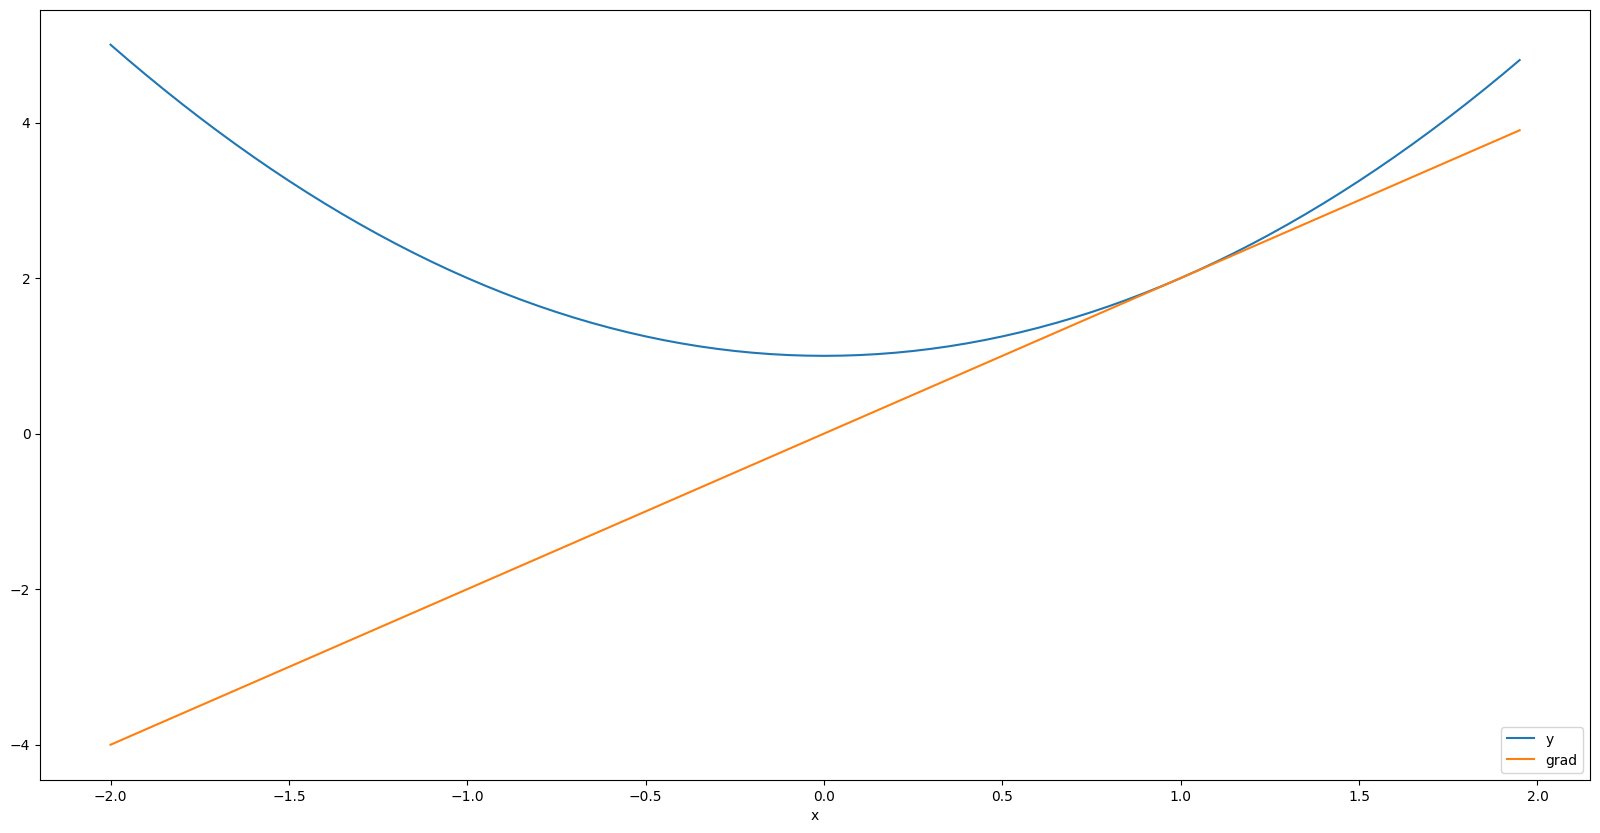

In [3]:
sample_data.plot(x = 'x')

Wniosek, jeśli nie możemy bezpośrednio znaleźć minimum funkcji `f(x)`, zawsze możemy spróbować sprawdzić, gdzie pochodna `f'(x)` jest równa `0` (a dla wielu rozwiązań sprawdź, która z nich jest minimum). To świetnie, ale co zrobić, gdy nie możemy rozwiązać równania `f'(x) == 0`? Żaden problem, zawsze możemy użyć bardzo prostego algorytmu o nazwie **Gradient Descent**:


1. Zacznij od wartości początkowej parametrów (x, y, beta, cokolwiek, ...)
2. Uaktualnij parametry formułą `param_new := param_old - LR * f'(param_old)` gdzie `LR` jest hiperparametrem zwanym **learning rate**. Wypróbujmy to dla naszej funkcji. Wypróbuj różne wartości learning rate, takie jak `0.1`, `0.01` i `1`

In [ ]:
x0 = 1.45
lr = 0.1
epochs = 30 # Liczba epok, czyli liczba aktualizacji wag

def GD_ordinary_fun(f, grad_f, x0, lr, epochs):
    x = x0
    results = pd.DataFrame({
        'x': [x0],
        'y': [f(x0)],
        'grad': [grad_f(x0)]
    })
    for i in range(1, epochs + 1):
        x = x - lr * grad_f(x) # Gradient Descent
        print("Updated x value:", round(x, 8), ". Updated f(x) value:", round(f(x), 8))
        results = pd.concat([results, pd.DataFrame({
            'x': [x],
            'y': [f(x)],
            'grad': [grad_f(x)]
    })])
    return results

task1 = GD_ordinary_fun(f, grad_f, x0, lr, epochs)

In [ ]:
ax = sample_data.plot(x = 'x')
task1.plot(ax = ax, x = 'x', y = 'y', kind = 'scatter')

Jeśli teraz możemy zaimplementować Gradient Descent dla prostej funkcji z jednym parametrem, możemy spróbować rozwiązać podstawowy problem uczenia maszynowego - regresję liniową.

In [6]:
random.seed(10)
sample_data = pd.DataFrame({
    'x': np.random.uniform(-3, 3, 50)
})
sample_data["y"] = sample_data.x + np.random.normal(3, 1.2, 50)
sample_data["intercept"] = 1

In [ ]:
sample_data.plot(x = 'x', y = 'y', kind = 'scatter')

Naszym zadaniem jest znalezienie parametrów `b0` i `b1` modelu liniowego `y = b0 + b1*x` takich aby błąd średniokwadratowy (mean squared error) był minimalny. Zanim zaczniemy, sprawdźmy rozwiązanie z pythona:

In [30]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

X = np.array(sample_data["x"]).reshape(-1, 1)
y = np.array(sample_data["y"]).reshape(-1, 1)

reg = LinearRegression().fit(X, y)
#print(X)
#print(sample_data["x"])
print("b0", reg.intercept_)
print("b1", reg.coef_)
print("MSE:", mean_squared_error(y, reg.predict(X)))

b0 [3.33564457]
b1 [[0.98085008]]
MSE: 1.300865518843226


In [31]:
X = np.concatenate((np.array(sample_data["intercept"]).reshape(-1, 1), X), axis=1)
#print(X)

Teraz musimy zaimplementować MSE:

In [32]:
def MSE(beta, X, y):
    betaX = np.matmul(beta, X.transpose())
    return np.mean((betaX - y[:,0])**2)


In [ ]:
# Podmień wartości 2.95522547, 1.00466319 na b0 i b1 wyznaczone powyżej
MSE(np.array([3.33564457, 0.98085008]), X, y)

oraz pochodną MSE:

In [35]:
def MSE_grad(beta, X, y):
    betaX = np.matmul(beta, X.transpose())
    return 2*np.matmul(betaX - y[:,0], X)/y.shape[0]

Szczerze mówiąc, nie musimy tutaj używać Gradient Descent, równanie `MSE_grad == 0` ma rozwiązanie numeryczne:

In [ ]:
np.matmul(np.matmul(np.linalg.inv(np.matmul(X.transpose(), X)), X.transpose()), y[:,0])

Ale powiedzmy, że naprawdę chcemy:

In [ ]:
beta00 = np.array([5, -0.2])
lr = 0.1
epochs = 30 # Liczba epok, czyli liczba aktualizacji wag (po całym datasecie)

def GD_linear_regression(beta00, X, y, lr, epochs):
    beta = beta00
    results = pd.DataFrame({
        'b0': [beta00[0]],
        'b1': [beta00[1]],
        'mse': [MSE(beta00, X, y)],
        'epoch': [0]
    })
    for i in range(1, epochs + 1):
        beta = beta - lr * MSE_grad(beta, X, y) # Gradient Descent
        print("Updated b0 value:", round(beta[0], 8), ". Updated b1 value:", round(beta[1], 8), ". Updated MSE value:", round(MSE(beta, X, y), 8))
        results = pd.concat([results, pd.DataFrame({
            'b0': [beta[0]],
            'b1': [beta[1]],
            'mse': [MSE(beta, X, y)],
            'epoch': [i]
    })])
    return results

task2 = GD_linear_regression(beta00, X, y, lr, epochs)

In [ ]:
prediction = pd.DataFrame({
    'x': sample_data.x
})
prediction["start"] = [beta00[0] + beta00[1]*x for x in prediction.x]
prediction["end"] = [task2.b0.iloc[-1] + task2.b1.iloc[-1]*x for x in prediction.x]
ax = sample_data.plot(x = 'x', y = 'y', kind = 'scatter')
prediction.plot(ax = ax, x = 'x')

In [ ]:
task2.plot(x = 'epoch', y = 'mse')

In [40]:
import itertools
beta_grid = list(itertools.product(np.arange(task2.b0.iloc[-1]-2, task2.b0.iloc[-1] +2, 0.1),
           np.arange(task2.b1.iloc[-1]-2, task2.b1.iloc[-1] +2, 0.1)))
beta_grid = pd.DataFrame({
    'b0': [x[0] for x in beta_grid],
    'b1': [x[1] for x in beta_grid]
})
beta_grid["mse"] = [MSE(np.array([b0, b1]), X, y) for b0, b1 in zip(beta_grid.b0, beta_grid.b1)]

In [ ]:
import seaborn as sns
sns.heatmap(beta_grid.pivot(index='b0', columns='b1', values='mse'), square=False, cmap="coolwarm")

In [ ]:
task2.plot(x = 'b1', y = 'b0', marker = ">")

Wiemy teraz, czym jest Gradient Descent i jak go używać do rozwiązywania problemów ML. W rzeczywistości często będziemy używać zaawansowanej wersji gradientu o nazwie **Stochastic Gradient Descent** lub **SGD** w skrócie. Wprowadzimy jedną małą zmianę w naszym algorytmie. Jak pamiętasz, nasz gradient MSE `MSE_grad` bierze pod uwagę macierz obliczeń `X` i wektor `y` i mnoży je na różne sposoby. Załóżmy na chwilę, że mamy miliony obserwacji, te mnożenia mogą zająć dużo czasu i pamięci, może być nawet niemożliwe. Istnieje proste rozwiązanie tego problemu. Nasze dane możemy podzielić na tzw. **batche**. Jeśli mamy np. 50 obserwacji, możemy je podzielić na 5 batchy - po 10 obserwacji każda. Po tych 5 batchach SGD zobaczy wszystkie obserwacje, które mieliśmy - minie pierwsza **epoka** i proces rozpocznie się od początku. Można o tym myśleć jako o dodatkowej pętli nad partiami wewnątrz pętli epok z implementacji GD.

In [ ]:
beta00 = np.array([5, -0.2])
lr = 0.1
epochs = 30 # Liczba epok, czyli liczba aktualizacji wag (po całym datasecie)
batch_size = 1 # Liczba podzbiorów w datasecie

def SGD_linear_regression(beta00, X, y, lr, epochs, batch_size):
    beta = beta00
    results = pd.DataFrame({
        'b0': [beta00[0]],
        'b1': [beta00[1]],
        'mse': [MSE(beta00, X, y)],
        'epoch': [0]
    })
    batches_per_epoch = int(np.ceil(y.shape[0] / batch_size))
    for i in range(1, epochs + 1):
        for b in range(1, batches_per_epoch + 1):
            X_b = X[((b - 1) * batch_size ):min((b * batch_size + 1), y.shape[0]), :]
            y_b = y[((b - 1) * batch_size ):min((b * batch_size + 1), y.shape[0]), :]
            beta = beta - lr * MSE_grad(beta, X_b, y_b) # Stochastic Gradient Descent
            print("Updated b0 value:", round(beta[0], 8), ". Updated b1 value:", round(beta[1], 8), ". Updated MSE value:", round(MSE(beta, X, y), 8))
            results = pd.concat([results, pd.DataFrame({
                'b0': [beta[0]],
                'b1': [beta[1]],
                'mse': [MSE(beta, X, y)],
                'epoch': [i + b / batches_per_epoch]
    })])
    return results

task3 = SGD_linear_regression(beta00, X, y, lr, epochs, batch_size)

In [ ]:
prediction = pd.DataFrame({
    'x': sample_data.x
})
prediction["start"] = [beta00[0] + beta00[1]*x for x in prediction.x]
prediction["end"] = [task3.b0.iloc[-1] + task3.b1.iloc[-1]*x for x in prediction.x]
ax = sample_data.plot(x = 'x', y = 'y', kind = 'scatter')
prediction.plot(ax = ax, x = 'x')

<Axes: xlabel='epoch'>

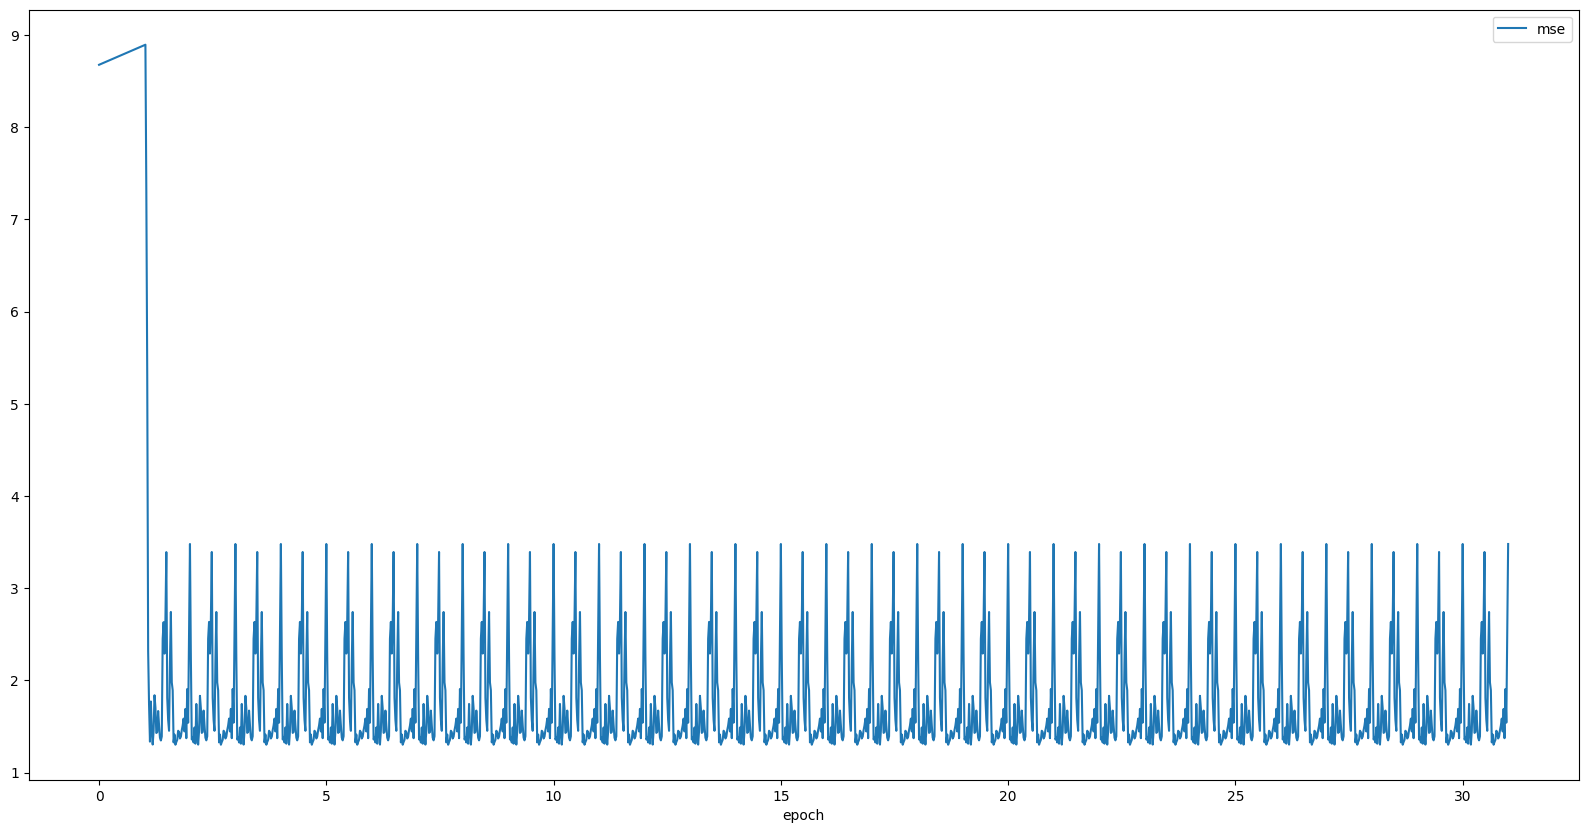

In [45]:
task3.plot(x = 'epoch', y = 'mse')

<Axes: xlabel='b1'>

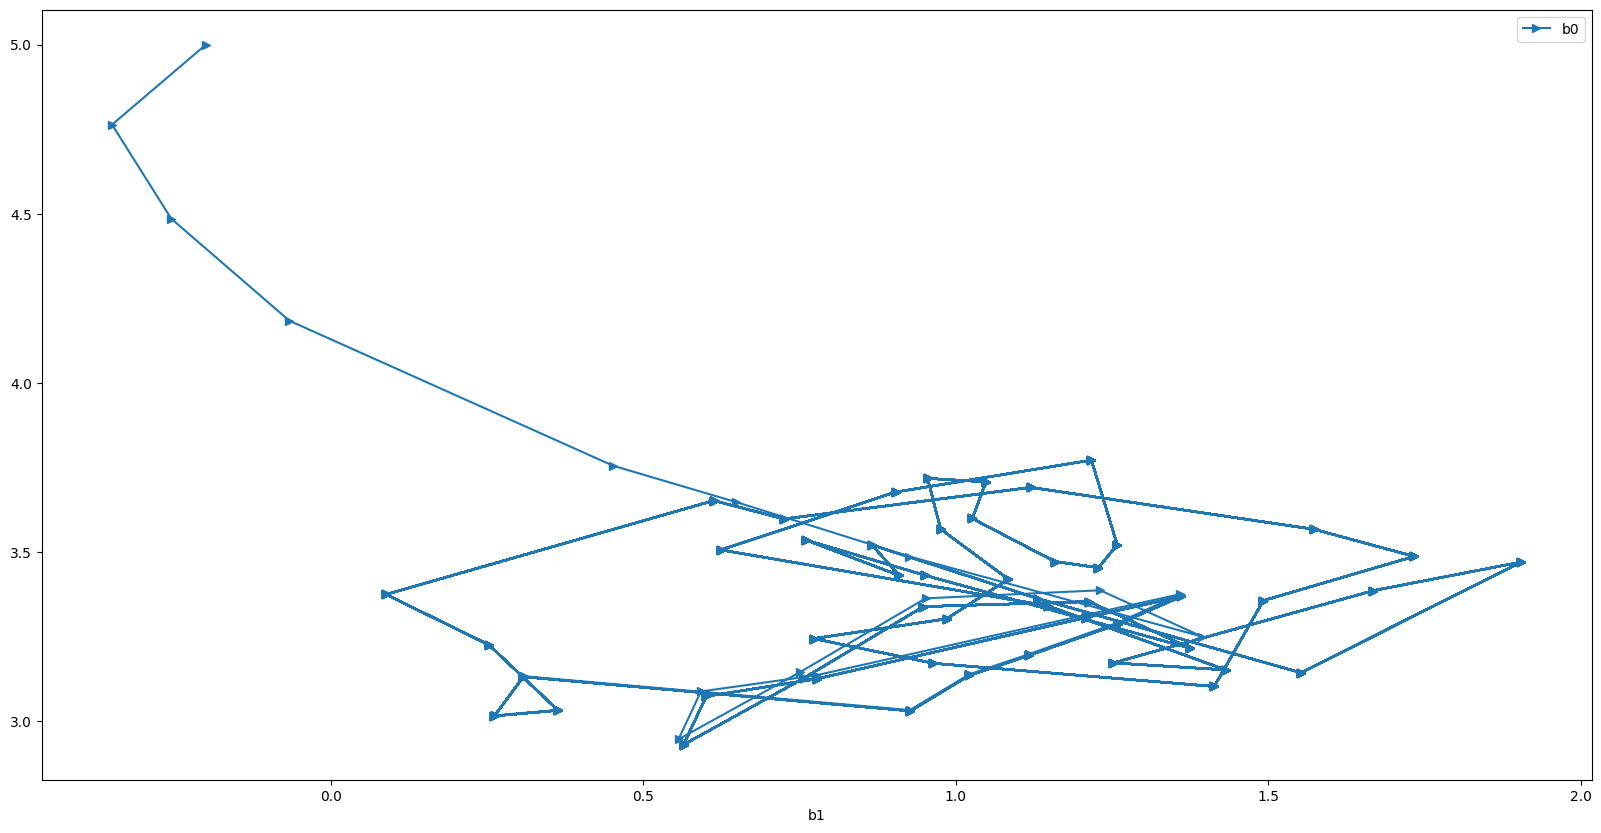

In [46]:
task3.plot(x = 'b1', y = 'b0', marker = ">")

W przypadku SGD obliczenia potrzebne do aktualizacji parametrów są szybsze niż w GD, ale SGD może potrzebować więcej kroków niż GD, aby zminimalizować funkcję. Jest jeszcze jedna ważna przewaga SGD nad GD - SGD może „wydostać się” z lokalnego minimum.

Kolejnym krokiem w zrozumieniu procesu optymalizacji będzie implementacja SGD dla regresji logistycznej. W przypadku regresji logistycznej nie ma rozwiązania nuerycznego, więc musimy użyć jakiegoś algorytmu

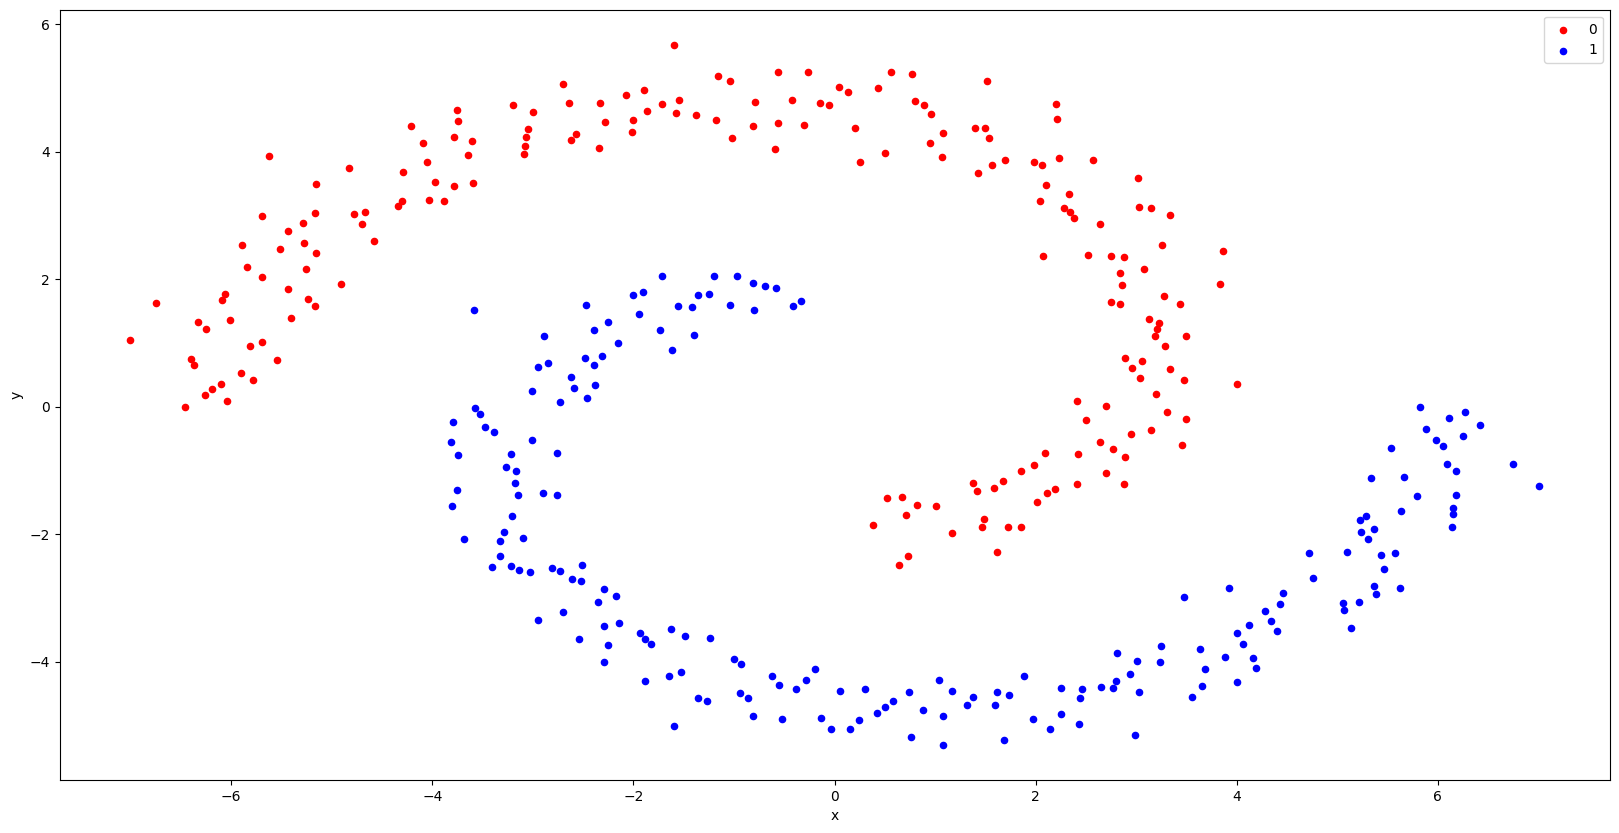

In [49]:
spirals = pd.read_csv("/content/spirals.csv")
spirals["intercept"] = 1
fig, ax = plt.subplots()

colors = {0:'red', 1:'blue'}

grouped = spirals.groupby('class')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])

plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Jak zawsze możemy sprawdzić rozwiązanie w Python. Python używa algorytmu scoringu Fishera lub algorytmu scoringu Newtona - algorytmy te wykorzystują nie tylko pierwszą, ale także drugą pochodną do aktualizacji parametrów. Korzystanie z drugiej pochodnej ma zalety, ale obliczenia są naprawdę czasochłonne i pochłaniają pamięć.

In [54]:
from sklearn.linear_model import LogisticRegression

X = np.array(spirals[["x", "y"]]).reshape(-1, 2)
y = np.array(spirals["class"]).reshape(-1, 1)

reg = LogisticRegression().fit(X, y.ravel())
print("b0", reg.intercept_)
print("b1 b2", reg.coef_)

b0 [0.00139355]
b1 b2 [[-0.04941552 -0.79912157]]


In [55]:
X = np.concatenate((np.array(spirals["intercept"]).reshape(-1, 1), X), axis=1)

Następnym krokiem jest zaimplementowanie funkcji **sigmoid** używanej w regresji logistycznej:

In [56]:
sigmoid = lambda x: 1 / (1 + np.exp(-x))

i jej pochodnej:

In [57]:
sigmoid_grad = lambda x: sigmoid(x) * (1 - sigmoid(x))

W przypadku klasyfikacji binarnej naszą funkcją straty będzie **binary crossentropy**:

In [58]:
def binary_crossentropy(beta, X, y):
    z = sigmoid(np.matmul(beta, X.transpose()))
    return -np.mean(y * np.log(z) + (1 - y) * np.log(1 - z))

Potrzebujemy również gradientu. Tutaj zastosujemy tak zwaną **regułę łańcuchową** dla pochodnych:

In [59]:
def binary_crossentropy_grad(beta, X, y):
    z = sigmoid(np.matmul(beta, X.transpose()))
    dL = (-y[:,0] / z - (1 - y[:,0]) / (z - 1)) / y.shape[0]
    dV = sigmoid_grad(np.matmul(beta, X.transpose()))
    dx = X
    return np.matmul((dL * dV), dx)

Teraz mamy wszystko do zaimplementowania SGD do regresji logistycznej:

In [ ]:
beta00 = np.array([0.3, 1, -0.2])
lr = 0.1
epochs = 20 # Liczba epok, czyli liczba aktualizacji wag (po całym datasecie)
batch_size = 20 # Liczba podzbiorów w datasecie

def SGD_logistic_regression(beta00, X, y, lr, epochs, batch_size):
    beta = beta00
    results = pd.DataFrame({
        'b0': [beta00[0]],
        'b1': [beta00[1]],
        'b2': [beta00[2]],
        'logloss': [binary_crossentropy(beta00, X, y)],
        'epoch': [0]
    })
    batches_per_epoch = int(np.ceil(y.shape[0] / batch_size))
    for i in range(1, epochs + 1):
        for b in range(1, batches_per_epoch + 1):
            X_b = X[((b - 1) * batch_size ):min((b * batch_size + 1), y.shape[0]), :]
            y_b = y[((b - 1) * batch_size ):min((b * batch_size + 1), y.shape[0]), :]
            beta = beta - lr * binary_crossentropy_grad(beta, X_b, y_b) # Stochastic Gradient Descent
            print("Updated b0 value:", round(beta[0], 8), ". Updated b1 value:", round(beta[1], 8), ". Updated b2 value:", round(beta[2], 8), ". Updated Logloss value:", round(binary_crossentropy(beta, X, y), 8))
            results = pd.concat([results, pd.DataFrame({
                'b0': [beta[0]],
                'b1': [beta[1]],
                'b2': [beta[2]],
                'logloss': [binary_crossentropy(beta, X, y)],
                'epoch': [i + b / batches_per_epoch]
    })])
    return results

task4 = SGD_logistic_regression(beta00, X, y, lr, epochs, batch_size)

<Axes: xlabel='epoch'>

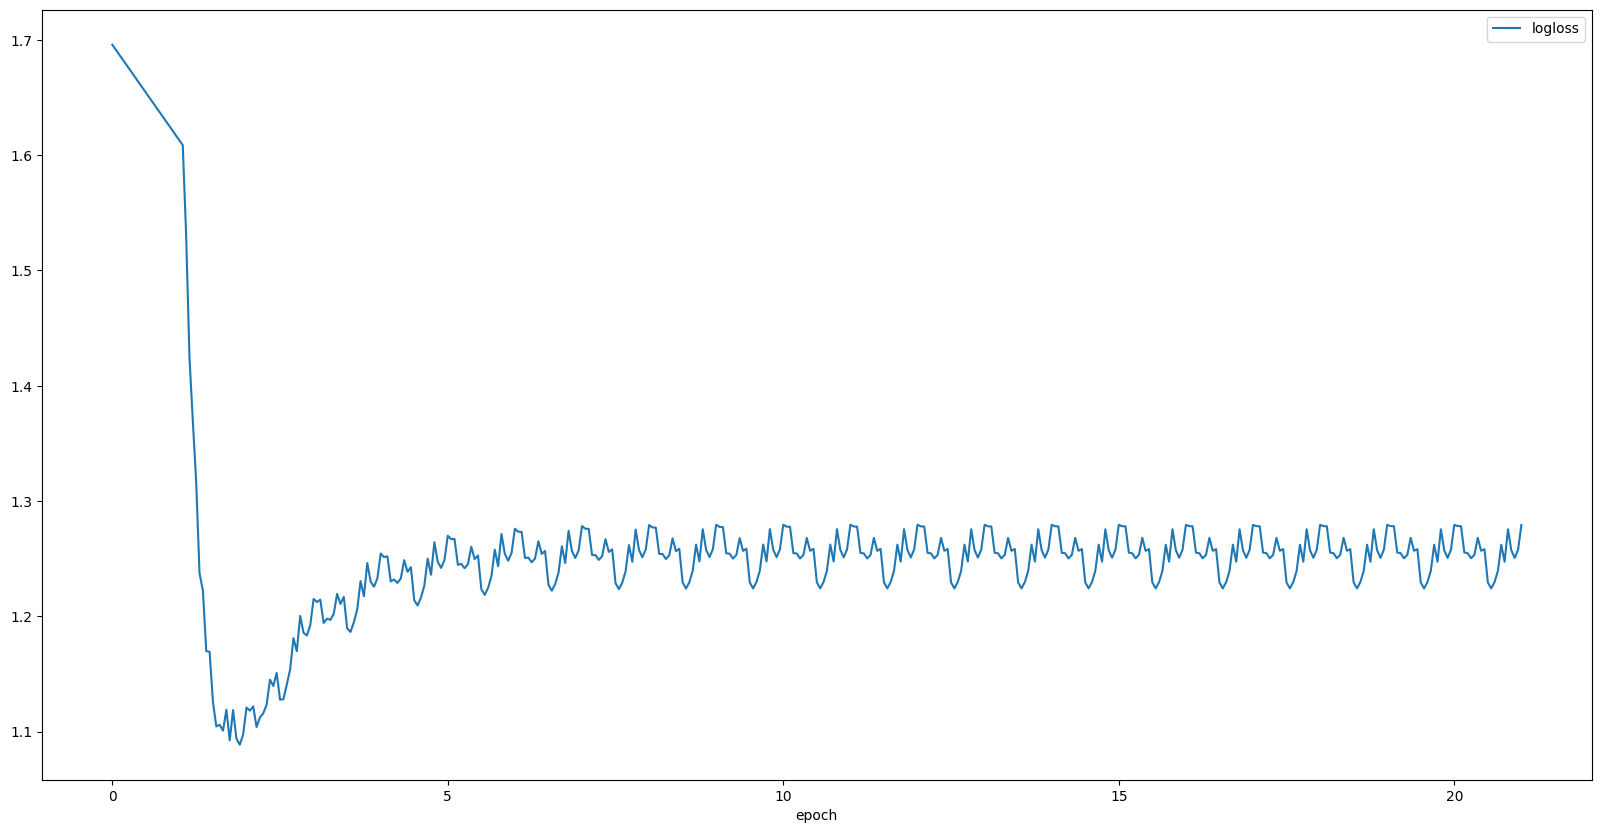

In [105]:
task4.plot(x = 'epoch', y = 'logloss')

In [106]:
xy_grid = list(itertools.product(np.arange(spirals.x.min(), spirals.x.max(), 0.1),
           np.arange(spirals.y.min(), spirals.y.max(), 0.1)))
xy_grid = pd.DataFrame({
    'x': [z[0] for z in xy_grid],
    'y': [z[1] for z in xy_grid]
})
xy_grid["class"] = [task4.b0.iloc[-1] + task4.b1.iloc[-1]*x + task4.b2.iloc[-1]*y for x, y in zip(xy_grid.x, xy_grid.y)]
xy_grid["class"] = sigmoid(xy_grid["class"]) > 0.5
xy_grid["class"] = xy_grid["class"].astype(int)

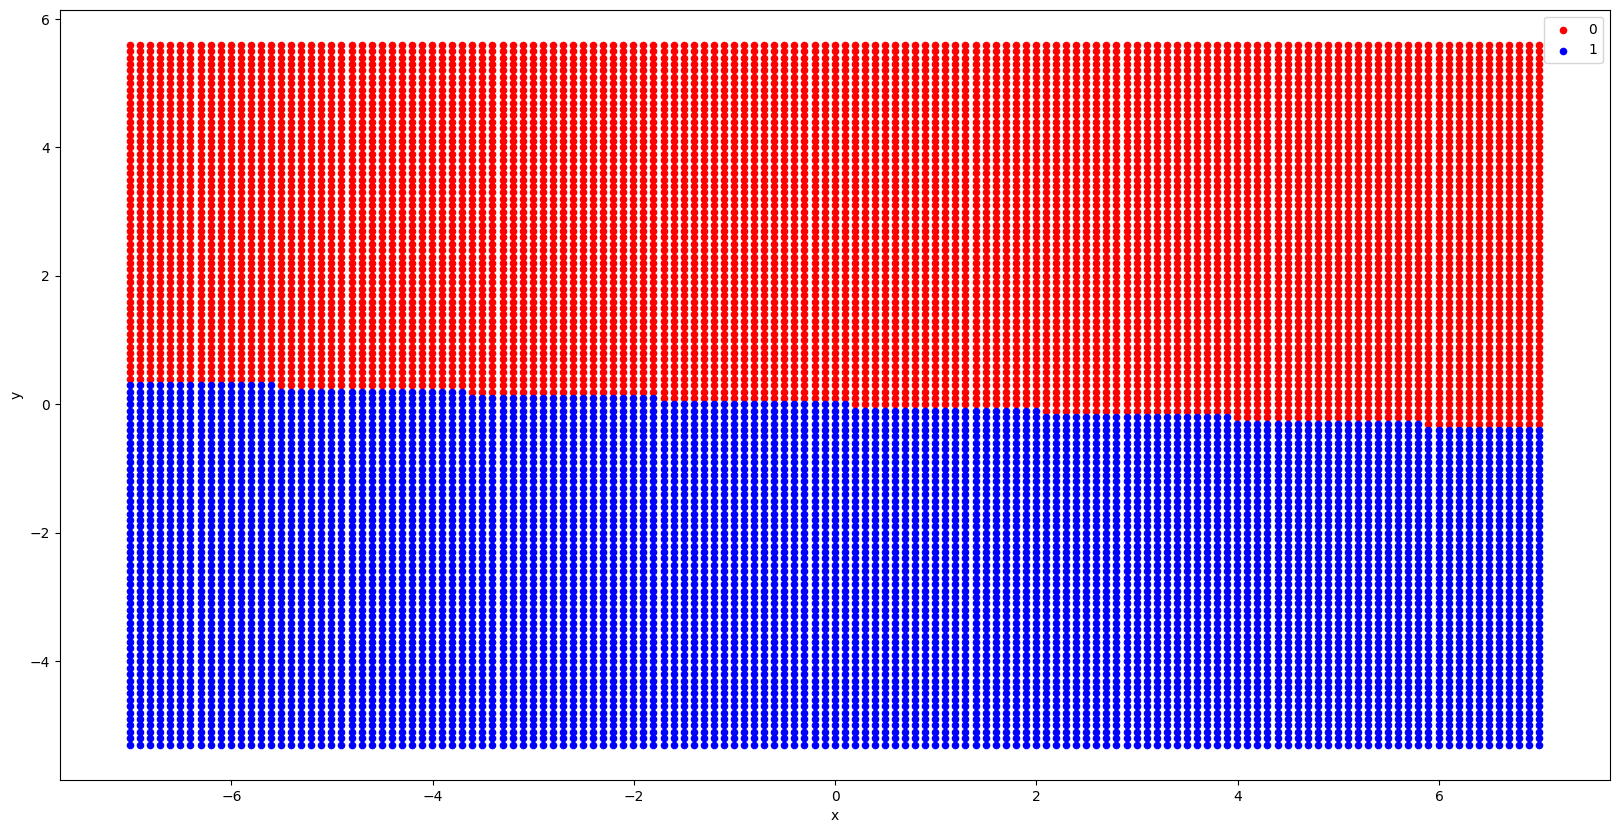

In [107]:
fig, ax = plt.subplots()

colors = {0:'red', 1:'blue'}

grouped = xy_grid.groupby('class')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])

plt.show()

**Pytanie**. Co myślisz o tych wynikach w kontekście klasyfikacji danych wejściowych?

**Odpowiedź:**  

**Zadanie**. Poeksperymentuj z ilością epok i rozmiarem batcha. Czy coś się zmieniło?

In [ ]:
# W danym przypadku wykazujemy ze regresja liniowa nie jest dobrym rozwiazaniem dla tego typu zadania
# Algorytm próbuje nam pokazac przypis liniowy, natomiast jak porownany pierwszy wykres z ostatnim widzimy ze nie ma on pokrycia.

#Epoki po kololo 10 nie wplywaja juz na wartosc predykcji, warto wykonac ich kolo 15, czy 20 by wykazac ze nie wplywaja juz one na srednia wartosc kolo 1,2-1,3
#Batch mniejszy powoduje wiekszy rozstrzal w logloss, natomiast wiekszy w prawie wykres liniowym,
# po danych nalezy znalezc optymalna wartosc - przy batch = 20 mozna zauwazyc ze ilosc epok potrzebnych zmniejsza sie i wlasciwe wartosci mozna zauwazyc juz po okolo 6

